<div class='alert'>

### Fine Tuning LLM - BERT

</div>

<div class='alert alert-success'>
Lets Start.

We will follow these steps:
1. Choose a pre-trained model and a dataset
2. Load the data
3. Tokenizer
4. Initialize our base model
5. Evaluate the method
6. Fine tune using the Trainer method
</div>

<div class='alert'>

#### 1. Choose a pre-trained model and a dataset

</div>

Lets use *`BERT`* model and a *`twitter dataset`*.

<div class='alert'>

#### 2. Load the dataset

</div>

In [1]:
from datasets import load_dataset

twitter_dataset = load_dataset("mteb/tweet_sentiment_extraction")
twitter_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})

Great!!! The dataset is loaded now.

As we can see there are two keys in the loaded dataset dictionary-`train` and `test`.

Lets check how our data looks like.

In [2]:
import pandas as pd

train_dataset_df = pd.DataFrame(twitter_dataset['train'])

train_dataset_df.head()

,id,text,label,label_text
0,cb774db0d1,"I`d have responded, if I were going",1,neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,0,negative
2,088c60f138,my boss is bullying me...,0,negative
3,9642c003ef,what interview! leave me alone,0,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",0,negative


Let's check how many training data we have and how many label classes we have.

In [3]:
print(f'We have total of {len(train_dataset_df)} training observations.')

print(f'We have {len(train_dataset_df['label_text'].unique())} label classes -> {train_dataset_df['label_text'].unique()} ')


We have total of 27481 training observations.
We have 3 label classes -> ['neutral' 'negative' 'positive'] 


Great. Let's quickly check if our data is imbalanced.

In [4]:
# check if the labels have balanced data

# counting the value and converting it to percentage
label_percentage = train_dataset_df['label_text'].value_counts() / len(train_dataset_df) * 100
label_percentage

label_text
neutral     40.457043
positive    31.228849
negative    28.314108
Name: count, dtype: float64

Good. Our data is not highly imbalanced. A little but not as bad.
Let's visualize it.

<BarContainer object of 3 artists>

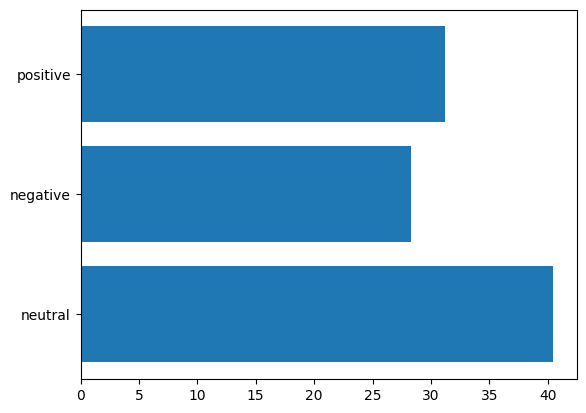

In [5]:
import matplotlib.pyplot as plt

plt.barh(['neutral', 'negative', 'positive'], [label_percentage['neutral'], label_percentage['negative'], label_percentage['positive']])

<div class='alert'>

#### 3. Base Evaluation
</div>

We can see from the label percentage that neutral has 40.46% of the data.

So, if we do not train our model and just randomly predicted `neutral`, we will be correct `40.46%` of the time.

So 40.46 is our base. 

The model we want to build should predict the classes better than this.

In [6]:
base_prediction_percentage = label_percentage.sort_values(ascending=False).iloc[0]
print(float(base_prediction_percentage))

40.45704304792402


<div class='alert'>

#### 4. Tokenizer
</div>

In order to pass the data to the pre-trained model, we need to tokenize it.

Since we chose `BERT` as the model we want to fine tune, we should choose the tokenizer for BERT as well.

We can do this by loading `google-bert/bert-base-cased`

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-cased')
tokenizer

BertTokenizerFast(name_or_path='google-bert/bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

As LLMs work with tokens, we need to tokenize our entire dataset using the tokenizer.

We can use map method to apply the preprocessing function over the entire dataset.

In [8]:
def tokenize_funtion(obervation):
    # we want to tokenize 'text' column from our data
    return tokenizer(obervation['text'], padding='max_length', truncation=True)

tokenized_dataset = twitter_dataset.map(tokenize_funtion, batched=True)

tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3534
    })
})

<div class='alert'>

#### 5. Initialize our pre-trained model
</div>

In [9]:
from transformers import BertForSequenceClassification

bert_model = BertForSequenceClassification.from_pretrained('google-bert/bert-base-uncased', num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# print the summary of the model
from torchinfo import summary

summary(bert_model)

Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   23,440,896
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                               --
├─L

We can see that we have 109 million parameters.

That means, when we fine-tune our model, it will tune those 109 million parameters.

We can decrease the number of trainable parameters using different techniques (for ex. LoRA), which will drastically decrease the number of trainable parameter with no loss in performance. 

We will do it later.

<div class='alert'>

#### 6. Initilaize the Evaluation and evaluate our pre-trained model
</div>


Default trainer doesn't give us information about accuracy, precision, recall, f1.

We have to write a custom function that handles this.

Lets do that now.

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def custom_metrics(predictions):
    pred, labels = predictions
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')
    # average = macro, we should do this for multiclass classfication
    # we can choose from micro, macro, and weighted options

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [12]:
from transformers import TrainingArguments, Trainer
import torch

torch.manual_seed(42)
#configure training arguments for the evaluation
# bert_model.eval()

training_arguments = TrainingArguments(
    per_device_eval_batch_size=1,
    prediction_loss_only=False,
    seed=42,
    data_seed=42
)

pre_trained_evaluator =  Trainer(
    model=bert_model,
    args=training_arguments,
    compute_metrics=custom_metrics
)

In [13]:
pre_trained_eval_results = pre_trained_evaluator.evaluate(tokenized_dataset['test'])

In [14]:
pd.DataFrame([pre_trained_eval_results], index=['Bert Pretrained Result']).transpose()

,Bert Pretrained Result
eval_loss,1.106310
eval_model_preparation_time,0.004100
eval_accuracy,0.310979
eval_precision,0.214811
eval_recall,0.331917
eval_f1,0.159338
eval_runtime,69.524600
eval_samples_per_second,50.831000
eval_steps_per_second,50.831000


Well well well!!!

The eval accuracy of pre-trained BERT is 30-40.46% (depending on different run), which is similar to  as just predicting `neutral` or other classes, as we saw before. 

So our pretrained BERT is just randomly guessing the output class. 

Now Lets start our fine-tuning and see if we can improve it.

<div class='alert'>

#### 7. Fine-tune the model

</div>

In [15]:
torch.manual_seed(42) # seed for reproducibility

training_arguments = TrainingArguments(
    output_dir='test_trainer',
    per_device_eval_batch_size=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    prediction_loss_only=False,
    seed=42,
    data_seed=42
)

trainer = Trainer(
   model=bert_model,
   args=training_arguments,
   train_dataset=tokenized_dataset['train'],
   eval_dataset=tokenized_dataset['test'],
   compute_metrics=custom_metrics,
)

#start the training
trainer.train()

Step,Training Loss
500,1.099700
1000,1.090300
1500,1.094900
2000,1.093200
2500,1.093500
3000,1.096800
3500,1.088100
4000,1.086500
4500,1.095600
5000,1.090000


TrainOutput(global_step=10305, training_loss=1.0902164227866478, metrics={'train_runtime': 5153.1061, 'train_samples_per_second': 15.999, 'train_steps_per_second': 2.0, 'total_flos': 2.168738656964813e+16, 'train_loss': 1.0902164227866478, 'epoch': 2.999345025835092})

Now, lets check the performance of the trained model.

In [16]:
from transformers import BertForSequenceClassification
# load the model
trained_model= BertForSequenceClassification.from_pretrained('test_trainer/checkpoint-2577', use_safetensors=True)

# print the summary of the model
summary(trained_model)


Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   23,440,896
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                               --
├─L

its the same 109 million parameter model, but it is fine tuned in twitter dataset now.

Lets evaluate the trained model now.

In [17]:
from transformers import TrainingArguments, Trainer

# configure the training arguments
training_arguments = TrainingArguments(
    per_device_eval_batch_size=1,
    prediction_loss_only=False,
    seed=42,
    data_seed=42
)

# initialize he evaluator
evaluator = Trainer(
    model=trained_model,
    args=training_arguments,
    compute_metrics=custom_metrics
)

In [18]:
# final evaluation result in test dataset
eval_results = evaluator.evaluate(tokenized_dataset['test'])

In [19]:
pd.DataFrame([eval_results], index = ['Bert fine-tuned result']).transpose()

,Bert fine-tuned result
eval_loss,0.733612
eval_model_preparation_time,0.003000
eval_accuracy,0.710526
eval_precision,0.717410
eval_recall,0.710982
eval_f1,0.713848
eval_runtime,67.592400
eval_samples_per_second,52.284000
eval_steps_per_second,52.284000


In [20]:
results = pd.DataFrame([pre_trained_eval_results, eval_results], index=['Pretrained Model', 'Fine-tuned Model'])

results.transpose()

,Pretrained Model,Fine-tuned Model
eval_loss,1.106310,0.733612
eval_model_preparation_time,0.004100,0.003000
eval_accuracy,0.310979,0.710526
eval_precision,0.214811,0.717410
eval_recall,0.331917,0.710982
eval_f1,0.159338,0.713848
eval_runtime,69.524600,67.592400
eval_samples_per_second,50.831000,52.284000
eval_steps_per_second,50.831000,52.284000


Good. We looks like our fine tuned model is twice as better as the pretrained BERT model.

It bumped from 30% -> 71%.

It is good but not as good. We need to make it even better. 

<div class='alert'>

#### 8. Making our model even better

</div>

Now, what can do to make our model even better?

Lets work on that now.